In this notebook, I test if the SDXL weights I'm using produce sensible results with diffuers. If not, the weights might be broken.

In [1]:
#!pip install -Uqq transformers diffusers 

In [2]:
import torch

In [3]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

In [4]:
from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionXLPipeline

In [5]:
model = "stabilityai/stable-diffusion-xl-base-1.0"
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae", torch_dtype=device_dtype)

In [6]:
pipe = StableDiffusionXLPipeline.from_pretrained(model, vae=vae, torch_dtype=device_dtype)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [7]:
pipe = pipe.to(device)

In [8]:
prompt  = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
nprompt = 'lowres, bad anatomy, worst quality, low quality'
size = 8*(756//8)

In [9]:
im = pipe(prompt, width=size, height=size, negative_prompt=nprompt)[0]

timestep_spacing = "leading" and timesteps=[981. 961. 941. 921. 901.] ...
sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [13.12041569 11.67605019 10.42504501  9.33807945  8.39068699] ...
At end of `set_timesteps`:
sigmas =  tensor([13.1204, 11.6761, 10.4250,  9.3381,  8.3907], device='mps:0') ...
timesteps = tensor([981., 961., 941., 921., 901.], device='mps:0') ...
add_time_ids.shape = torch.Size([2, 6])
add_text_embeds.shape = torch.Size([2, 1280])


  0%|          | 0/50 [00:00<?, ?it/s]

latents.shape=[2, 4, 94, 94] | t=981.0 | enc_h.shape=[2, 77, 2048] | cross_attn_kw is None | added_cond_kw.keys=['text_embeds', 'time_ids']
latents.shape=[2, 4, 94, 94] | t=961.0 | enc_h.shape=[2, 77, 2048] | cross_attn_kw is None | added_cond_kw.keys=['text_embeds', 'time_ids']
latents.shape=[2, 4, 94, 94] | t=941.0 | enc_h.shape=[2, 77, 2048] | cross_attn_kw is None | added_cond_kw.keys=['text_embeds', 'time_ids']
latents.shape=[2, 4, 94, 94] | t=921.0 | enc_h.shape=[2, 77, 2048] | cross_attn_kw is None | added_cond_kw.keys=['text_embeds', 'time_ids']
latents.shape=[2, 4, 94, 94] | t=901.0 | enc_h.shape=[2, 77, 2048] | cross_attn_kw is None | added_cond_kw.keys=['text_embeds', 'time_ids']
latents.shape=[2, 4, 94, 94] | t=881.0 | enc_h.shape=[2, 77, 2048] | cross_attn_kw is None | added_cond_kw.keys=['text_embeds', 'time_ids']
latents.shape=[2, 4, 94, 94] | t=861.0 | enc_h.shape=[2, 77, 2048] | cross_attn_kw is None | added_cond_kw.keys=['text_embeds', 'time_ids']
latents.shape=[2, 4,

In [12]:
pipe.unet.add_time_proj??

Signature:       pipe.unet.add_time_proj(*args, **kwargs)
Type:            Timesteps
String form:     Timesteps()
File:            ~/Documents/GitHub/diffusers/diffusers/src/diffusers/models/embeddings.py
Source:         
class Timesteps(nn.Module):
    def __init__(self, num_channels: int, flip_sin_to_cos: bool, downscale_freq_shift: float):
        super().__init__()
        self.num_channels = num_channels
        self.flip_sin_to_cos = flip_sin_to_cos
        self.downscale_freq_shift = downscale_freq_shift

    def forward(self, timesteps):
        t_emb = get_timestep_embedding(
            timesteps,
            self.num_channels,
            flip_sin_to_cos=self.flip_sin_to_cos,
            downscale_freq_shift=self.downscale_freq_shift,
        )
        return t_emb
Class docstring:
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the subm

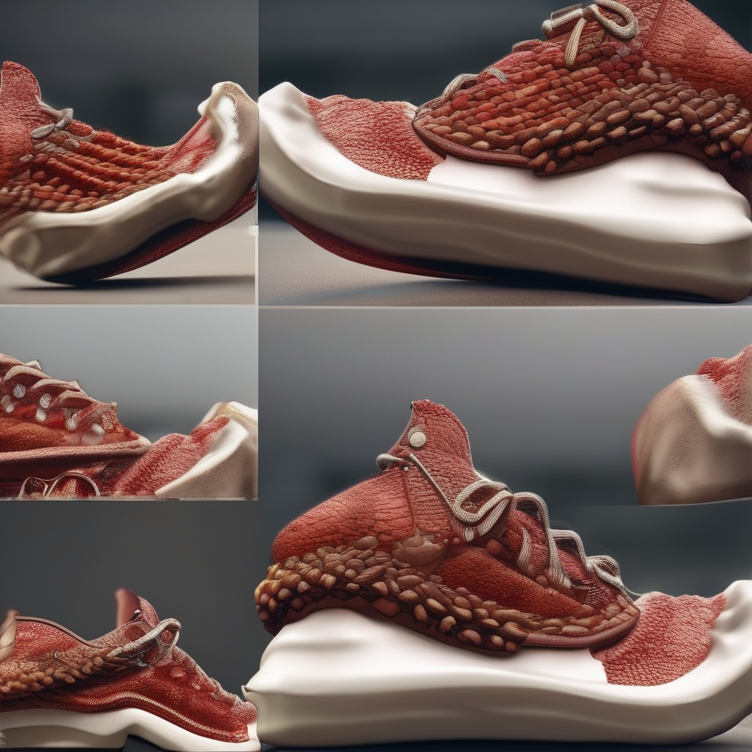

In [10]:
im[0]

In [11]:
im = pipe(prompt, width=size, height=size, negative_prompt=nprompt, num_inference_steps=10)[0]

  0%|          | 0/10 [00:00<?, ?it/s]

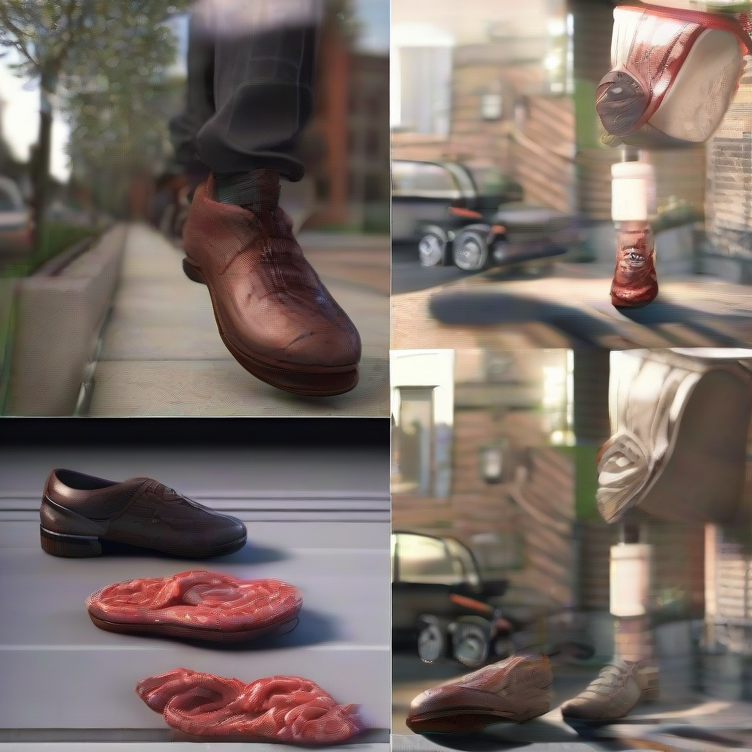

In [12]:
im[0]

___

Let's doodle around with SDXL

In [13]:
from util import public_attrs

In [14]:
unet = pipe.unet
type(unet)

diffusers.models.unet_2d_condition.UNet2DConditionModel

In [15]:
def class_names(modules): return [m.__class__.__name__ for m in modules]

In [16]:
class_names(unet.down_blocks)

['DownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D']

In [17]:
class_names(unet.up_blocks)

['CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'UpBlock2D']

In [18]:
unet.time_embedding

TimestepEmbedding(
  (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
)

In [19]:
unet.time_embedding.linear_2.out_features

1280

In [20]:
type(unet.encoder_hid_proj)

NoneType

In [21]:
unet.down_blocks[1].attentions[0]

Transformer2DModel(
  (norm): GroupNorm(32, 640, eps=1e-06, affine=True)
  (proj_in): LoRACompatibleLinear(in_features=640, out_features=640, bias=True)
  (transformer_blocks): ModuleList(
    (0-1): 2 x BasicTransformerBlock(
      (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
      (attn1): Attention(
        (to_q): LoRACompatibleLinear(in_features=640, out_features=640, bias=False)
        (to_k): LoRACompatibleLinear(in_features=640, out_features=640, bias=False)
        (to_v): LoRACompatibleLinear(in_features=640, out_features=640, bias=False)
        (to_out): ModuleList(
          (0): LoRACompatibleLinear(in_features=640, out_features=640, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
      (attn2): Attention(
        (to_q): LoRACompatibleLinear(in_features=640, out_features=640, bias=False)
        (to_k): LoRACompatibleLinear(in_features=2048, out_features=640,

In [22]:
unet.down_blocks[1].attentions[0].transformer_blocks[0].attn1.to_k.in_features

640

In [23]:
def cross_attn_input_size(b,a,t):
    net = unet.down_blocks[b].attentions[a].transformer_blocks[t]
    return net.attn1.to_k.in_features,net.attn2.to_k.in_features

In [24]:
for d in (1,2):
    for a in (0,1):
        for t in range(10):
            if d!=2 and t>=2: continue
            s1,s2=cross_attn_input_size(d,a,t)
            print(f'{d},{a},{t} -> {s1} | {s2}')

1,0,0 -> 640 | 2048
1,0,1 -> 640 | 2048
1,1,0 -> 640 | 2048
1,1,1 -> 640 | 2048
2,0,0 -> 1280 | 2048
2,0,1 -> 1280 | 2048
2,0,2 -> 1280 | 2048
2,0,3 -> 1280 | 2048
2,0,4 -> 1280 | 2048
2,0,5 -> 1280 | 2048
2,0,6 -> 1280 | 2048
2,0,7 -> 1280 | 2048
2,0,8 -> 1280 | 2048
2,0,9 -> 1280 | 2048
2,1,0 -> 1280 | 2048
2,1,1 -> 1280 | 2048
2,1,2 -> 1280 | 2048
2,1,3 -> 1280 | 2048
2,1,4 -> 1280 | 2048
2,1,5 -> 1280 | 2048
2,1,6 -> 1280 | 2048
2,1,7 -> 1280 | 2048
2,1,8 -> 1280 | 2048
2,1,9 -> 1280 | 2048


In [25]:
def attn_bias(b,a,t): return unet.down_blocks[b].attentions[a].transformer_blocks[t].attn1.to_k.bias is not None

In [26]:
for d in (1,2):
    for a in (0,1):
        for t in range(10):
            if d!=2 and t>=2: continue
            b=attn_bias(d,a,t)
            print(f'{d},{a},{t} -> {b}')

1,0,0 -> False
1,0,1 -> False
1,1,0 -> False
1,1,1 -> False
2,0,0 -> False
2,0,1 -> False
2,0,2 -> False
2,0,3 -> False
2,0,4 -> False
2,0,5 -> False
2,0,6 -> False
2,0,7 -> False
2,0,8 -> False
2,0,9 -> False
2,1,0 -> False
2,1,1 -> False
2,1,2 -> False
2,1,3 -> False
2,1,4 -> False
2,1,5 -> False
2,1,6 -> False
2,1,7 -> False
2,1,8 -> False
2,1,9 -> False


___

### Let's save the model and reload it from locally saved weights

In [27]:
pipe.save_pretrained('weights/sdxlvae')

In [28]:
assert False

AssertionError: 

Restart kernel now

___

In [1]:
import torch
from diffusers import StableDiffusionXLPipeline

In [3]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

In [4]:
pipe = StableDiffusionXLPipeline.from_pretrained('weights/sdxlvae').to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
prompt  = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
nprompt = 'lowres, bad anatomy, worst quality, low quality'
size = 8*(756//8)

  0%|          | 0/50 [00:00<?, ?it/s]

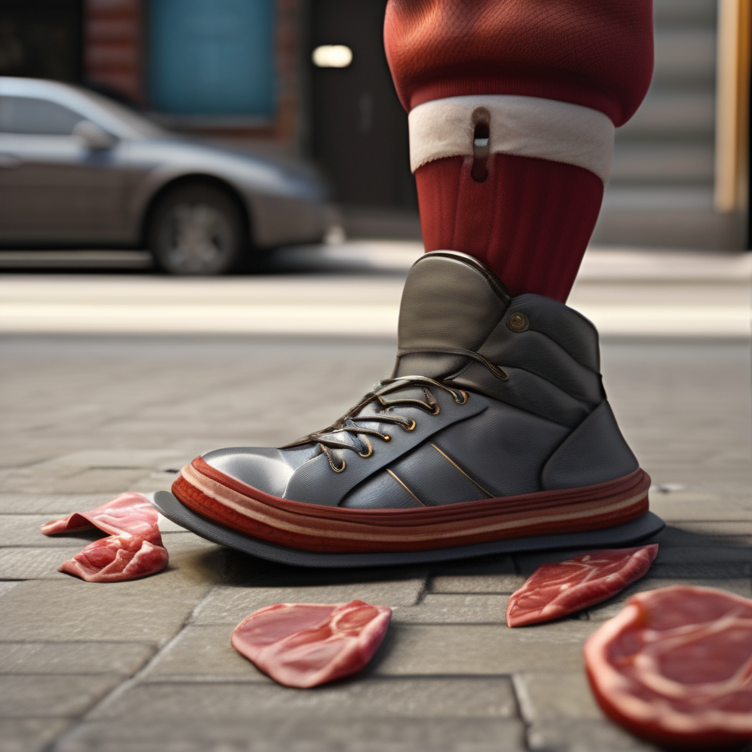

In [6]:
pipe(prompt, width=size, height=size, negative_prompt=nprompt, num_inference_steps=50)[0][0]